In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

### Look at the relevant part of the data
As you can see, we have multiple radon measurements (log-converted to be on the real line) in a county and whether the house has a basement (floor == 0) or not (floor == 1). We are interested in whether having a basement increases the radon measured in the house.


In [2]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


### Non-hierachical model first
To really highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical Bayesian model from above (separate regressions). For each county a new estimate of the parameters is initiated. As we have no prior information on what the intercept or regressions could be we are placing a Normal distribution centered around 0 with a wide standard-deviation. We'll assume the measurements are normally distributed with noise ϵ on which we place a Half-Cauchy distribution.

In [ ]:
# takes about 45 minutes
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace

### Hierachical Model
Instead of initiating the parameters separatly, the hierarchical model initiates group parameters that consider the county's not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's alpha and beta. 

In [3]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.county.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [5]:
with hierarchical_model:
    hierarchical_trace = pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains, 12 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 234.40draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


//anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has 

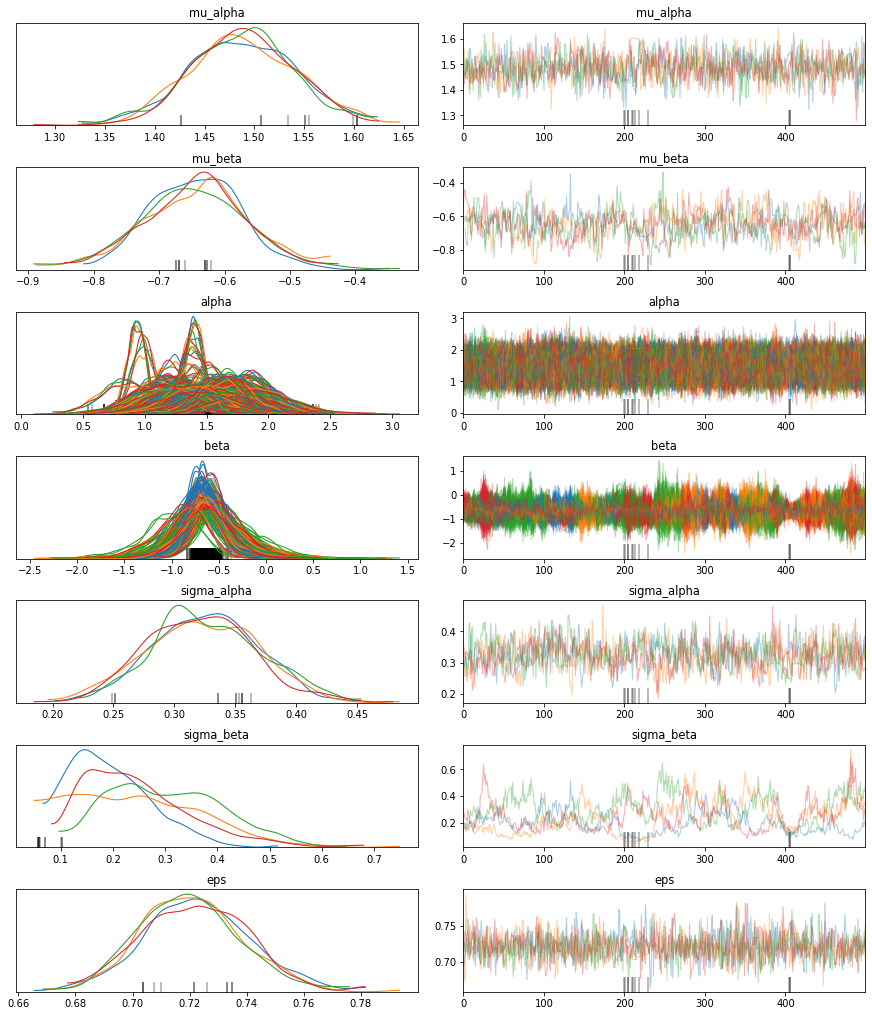

In [6]:
pm.traceplot(hierarchical_trace);

The marginal posteriors in the left column are highly informative. mu_a tells us the group mean (log) radon levels. mu_b tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for a that there is quite some differences in radon levels between counties; the different widths are related to how much measurements we have per county, the more, the higher our confidence in that parameter estimate.